# **Author : Devarsh Patel**

# Task 4 : Stock Market Prediction using Numerical and Textual Analysis

**GRIP @ The Sparks Foundation**

- To prediction the stock prices of SENSEX (S&P BSE SENSEX)
- Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

- Stocks data source : finance.yahoo.com
- News headline data : https://bit.ly/36fFPI6

**Importing libraries**

In [4]:
import os
import re
import math
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

import xgboost
import lightgbm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Time series data analysis

In [9]:
stocks = pd.read_csv('^BSESN.csv', parse_dates=['Date'])
stocks

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0
...,...,...,...,...,...,...,...
5039,2021-03-02,50258.089844,50439.820313,49807.121094,50296.890625,50296.890625,17500.0
5040,2021-03-03,50738.210938,51539.890625,50512.839844,51444.648438,51444.648438,15800.0
5041,2021-03-04,50812.140625,51256.550781,50539.921875,50846.078125,50846.078125,21800.0
5042,2021-03-05,50517.359375,50886.191406,50160.539063,50405.320313,50405.320313,19200.0


In [10]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5044 non-null   datetime64[ns]
 1   Open       4967 non-null   float64       
 2   High       4967 non-null   float64       
 3   Low        4967 non-null   float64       
 4   Close      4967 non-null   float64       
 5   Adj Close  4967 non-null   float64       
 6   Volume     4967 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 276.0 KB


In [11]:
stocks.isnull().sum()

Date          0
Open         77
High         77
Low          77
Close        77
Adj Close    77
Volume       77
dtype: int64

In [45]:
stocks = stocks.drop_duplicates()
stocks = stocks.dropna()
stocks.reset_index(drop=True, inplace=True)

In [46]:
stocks

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,0.010237
1,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,0.013633
2,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,0.016611
3,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,-0.015130
4,2001-01-09,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0,0.001184
...,...,...,...,...,...,...,...,...
4961,2021-03-02,50258.089844,50439.820313,49807.121094,50296.890625,50296.890625,17500.0,0.008968
4962,2021-03-03,50738.210938,51539.890625,50512.839844,51444.648438,51444.648438,15800.0,0.022820
4963,2021-03-04,50812.140625,51256.550781,50539.921875,50846.078125,50846.078125,21800.0,-0.011635
4964,2021-03-05,50517.359375,50886.191406,50160.539063,50405.320313,50405.320313,19200.0,-0.008668


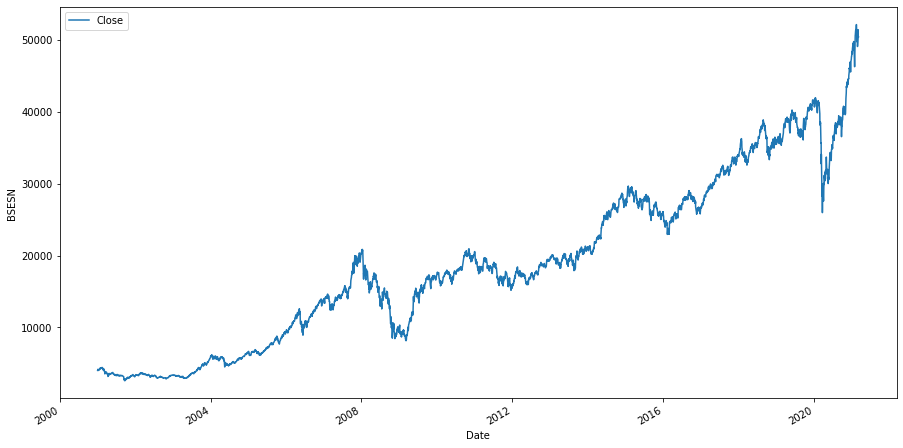

In [14]:
stocks.plot('Date', 'Close', figsize=(15, 8), ylabel='BSESN')

**Moving Average**

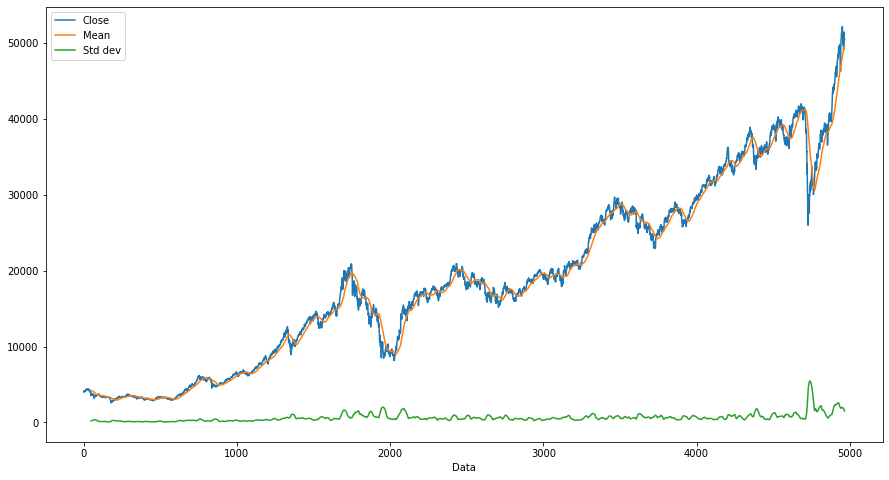

In [15]:
close = stocks['Close']

mean = close.rolling(window=50).mean()
std = close.rolling(window=50).std()

plt.figure(figsize=(15, 8))
close.plot(label='Close')
mean.plot(label='Mean')
std.plot(label='Std dev')
plt.xlabel('Data')
plt.legend()

**Returns**

Text(0.5, 0, 'Date')

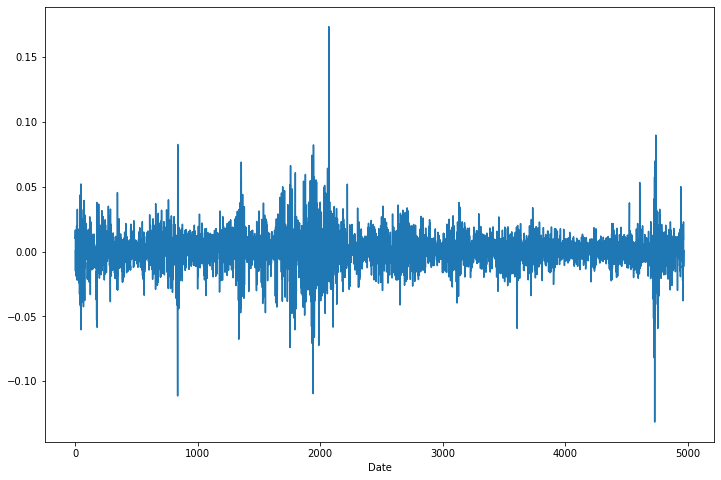

In [16]:
stocks['Return'] = stocks['Adj Close'].pct_change()
stocks['Return'].plot(figsize=(12, 8))
plt.xlabel('Date')

**Stationary test**

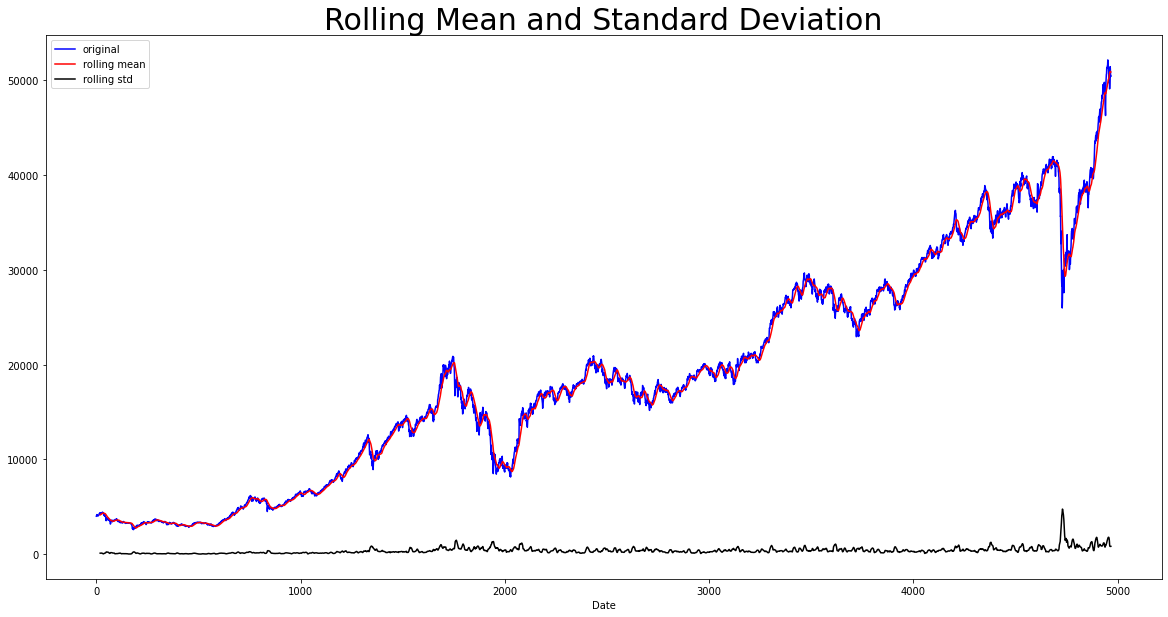

Results of dickey fuller test
ADF Test Statistic : 0.6929296293828154
p-value : 0.989695706924894
#Lags Used : 28
Number of Observations Used : 4938
Weak evidence against null hypothesis, time series is non-stationary 


In [17]:
def test_stationarity(timeseries):

    #Determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    plt.plot(timeseries, color='blue', label='original')
    plt.plot(rolmean, color='r', label='rolling mean')
    plt.plot(rolstd, color='black', label='rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation', fontsize=30)
    plt.show(block=False)

    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag='AIC')
    labels = [
        'ADF Test Statistic', 'p-value', '#Lags Used',
        'Number of Observations Used'
    ]
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print(
            "Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary"
        )
    else:
        print(
            "Weak evidence against null hypothesis, time series is non-stationary "
        )


test_stationarity(stocks['Close'])

# LSTM network to predict future stock prices

In [55]:
def create_dataset(df, look_back=1):
    dataX, dataY = [], []

    for i in range(len(df) - look_back - 1):
        a = df[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(df[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [47]:
stocks.dropna(inplace=True)
stock_values = stocks['Close'].values.astype('float32')

## Data pre-processing and feature scaling

In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))

stock_values = scaler.fit_transform(stock_values.reshape(-1, 1))

n_train = len(stock_values) * 2 // 3
n_test = len(stock_values) - n_train

In [58]:
train, test = stock_values[:n_train, :], stock_values[-n_test:, :]

In [59]:
look_back = 3

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

## Creating LSTM model

In [65]:
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=14, batch_size=1, verbose=2)

Epoch 1/14
3306/3306 - 7s - loss: 0.0030
Epoch 2/14
3306/3306 - 5s - loss: 4.4062e-05
Epoch 3/14
3306/3306 - 5s - loss: 4.4958e-05
Epoch 4/14
3306/3306 - 5s - loss: 4.3595e-05
Epoch 5/14
3306/3306 - 5s - loss: 4.1172e-05
Epoch 6/14
3306/3306 - 5s - loss: 3.8540e-05
Epoch 7/14
3306/3306 - 5s - loss: 3.6162e-05
Epoch 8/14
3306/3306 - 5s - loss: 3.0874e-05
Epoch 9/14
3306/3306 - 5s - loss: 2.8041e-05
Epoch 10/14
3306/3306 - 5s - loss: 2.5145e-05
Epoch 11/14
3306/3306 - 5s - loss: 2.5399e-05
Epoch 12/14
3306/3306 - 5s - loss: 2.3934e-05
Epoch 13/14
3306/3306 - 5s - loss: 2.3976e-05
Epoch 14/14
3306/3306 - 5s - loss: 2.2529e-05


In [66]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

## Ploting prediction



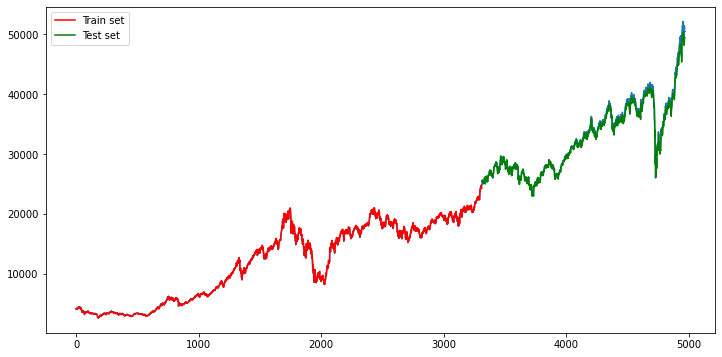

In [77]:
plt.figure(figsize=(12, 6))

trainPredictPlot = np.empty_like(stock_values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(stock_values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(stock_values) -
                1, :] = testPredict

plt.plot(scaler.inverse_transform(stock_values))
plt.plot(trainPredictPlot, color='red', label='Train set')
plt.plot(testPredictPlot, color='green', label='Test set')

plt.legend()
plt.show()

In [75]:
train_score = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print("Root mean square error = ", trainScore, "RMSE")
test_score = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print("Root mean square error = ", testScore, "RMSE")

Root mean square error =  204.48437525014333 RMSE
Root mean square error =  564.5933210246053 RMSE


# Hybrid model for Numerical and textual analysis

In [105]:
headlines = pd.read_csv('india-news-headlines.csv',
                        usecols=[0, 2],
                        names=['Date', 'News'],
                        skiprows=1,
                        parse_dates=['Date'])
headlines

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424062,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Govt extends deadline for use of FASTag till F...


In [106]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 52.2+ MB


In [107]:
headlines['News'] = headlines.groupby(['Date']).transform(lambda x: ' '.join(x))

headlines = headlines.drop_duplicates()
headlines.reset_index(inplace=True, drop=True)
headlines

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


## Sentiment analysis

In [110]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity


def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [113]:
headlines['Subjectivity'] = headlines['News'].apply(getSubjectivity)
headlines['Polarity'] = headlines['News'].apply(getPolarity)
headlines

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


In [114]:
headlines

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


### Visualizing distribution

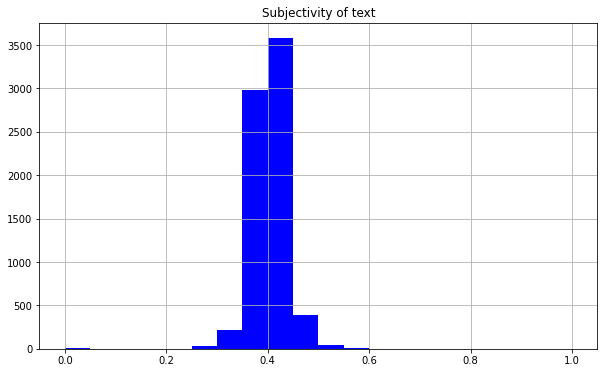

In [125]:
plt.figure(figsize=(10, 6))
plt.title('Subjectivity of text')
headlines['Subjectivity'].hist(color='blue', bins=20)

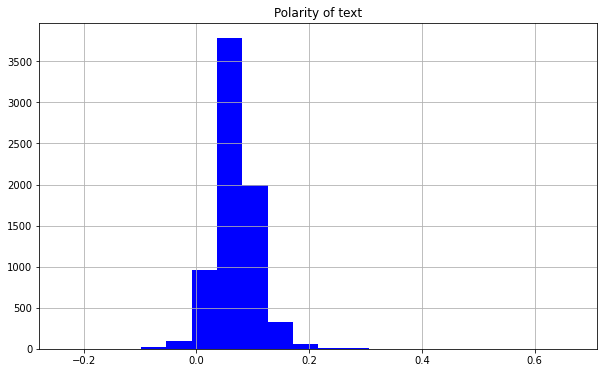

In [124]:
plt.figure(figsize=(10, 6))
plt.title('Polarity of text')
headlines['Polarity'].hist(color='blue', bins=20)

### Performing sentiment analysis

In [154]:
sia = SentimentIntensityAnalyzer()

scores = np.vectorize(sia.polarity_scores)

arr = scores(headlines['News'][:4000])
arr1 = scores(headlines['News'][4000:])
arr2 = np.concatenate((arr,arr1))

In [159]:
headlines['Compound'] = [i['compound'] for i in arr2]
headlines['Negative'] = [i['neg'] for i in arr2]
headlines['Neutral'] = [i['neu'] for i in arr2]
headlines['Positive'] = [i['pos'] for i in arr2]
headlines

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886,-0.9997,0.126,0.798,0.076
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.137,0.771,0.092
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.148,0.758,0.094
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.141,0.780,0.079


## Getting data ready for hybrid model

In [165]:
df_merge = pd.merge(stocks, headlines, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,Return,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,0.010237,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
1,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,0.013633,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
2,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,0.016611,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
3,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,-0.015130,Sangh Parivar; Babri panel up the ante Frontru...,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
4,2001-01-09,4114.740234,4166.839844,4101.009766,4125.310059,4125.310059,0.0,0.001184,Financier Bharat Shah held for alleged links w...,0.501934,-0.003837,-0.9948,0.138,0.809,0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4887,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539063,46973.539063,13700.0,0.011398,How to set the mood for sex during cold winter...,0.390942,0.048166,-0.9988,0.092,0.842,0.066
4888,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,0.008094,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.137,0.771,0.092
4889,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,0.005476,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.148,0.758,0.094
4890,2020-12-30,47789.031250,47807.851563,47358.359375,47746.218750,47746.218750,15600.0,0.002796,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.141,0.780,0.079


In [167]:
data = df_merge[['Close', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral','Positive']]

data

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4060.020020,0.407692,0.088462,-0.2640,0.122,0.766,0.111
1,4115.370117,0.446847,0.087961,0.8738,0.100,0.797,0.103
2,4183.729980,0.476612,0.262024,0.9633,0.124,0.722,0.154
3,4120.430176,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
4,4125.310059,0.501934,-0.003837,-0.9948,0.138,0.809,0.053
...,...,...,...,...,...,...,...
4887,46973.539063,0.390942,0.048166,-0.9988,0.092,0.842,0.066
4888,47353.750000,0.412945,0.070517,-0.9998,0.137,0.771,0.092
4889,47613.078125,0.424021,0.061210,-0.9999,0.148,0.758,0.094
4890,47746.218750,0.441660,0.043496,-0.9999,0.141,0.780,0.079


In [168]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
preprocessed_data = pd.DataFrame(sc.fit_transform(data))
preprocessed_data.columns = data.columns
preprocessed_data.index = data.index
preprocessed_data.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.032334,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
1,0.033559,0.446847,0.438129,0.93690,0.225225,0.797,0.169408
2,0.035073,0.476612,0.675488,0.98165,0.279279,0.722,0.253289
3,0.033672,0.414653,0.291981,0.01105,0.272523,0.812,0.108553
4,0.033780,0.501934,0.312949,0.00260,0.310811,0.809,0.087171


In [169]:
X = preprocessed_data.drop('Close', axis=1)
y = preprocessed_data['Close']

In [171]:
X.shape, y.shape

((4892, 6), (4892,))

## Testing different models

Splitting data into train and test data

In [173]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2021)
x_train.shape, y_train.shape

((3913, 6), (3913,))

In [215]:
score = {
    'Decision Tree Regressor': None,
    'Random Forest Regressor': None,
    'AdaBoost Regressor': None,
    'LGMB Regressor': None,
    'XGB Regressor': None
}

### Decision Tree Regression Model

In [216]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

score['Decision Tree Regressor'] = mean_squared_error(predictions, y_test)
print('Mean Squared error: ', score['Decision Tree Regressor'])
print('Root Mean Squared error: ', math.sqrt(score['Decision Tree Regressor']))

Mean Squared error:  0.041160927146440034
Root Mean Squared error:  0.20288155940459457


### Random Forest Regression Model

In [217]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
predictions = rfr.predict(x_test)

score['Random Forest Regressor'] = mean_squared_error(predictions, y_test)
print('Mean Squared error: ', score['Random Forest Regressor'])
print('Root Mean Squared error: ', math.sqrt(score['Random Forest Regressor']))

Mean Squared error:  0.0231023716129327
Root Mean Squared error:  0.15199464336920793


### AdaBoost Regression Model

In [218]:
abr = AdaBoostRegressor()
abr.fit(x_train, y_train)
predictions = abr.predict(x_test)

score['AdaBoost Regressor'] = mean_squared_error(predictions, y_test)
print('Mean Squared error: ', score['AdaBoost Regressor'])
print('Root Mean Squared error: ', math.sqrt(score['AdaBoost Regressor']))

Mean Squared error:  0.027827639999083973
Root Mean Squared error:  0.16681618626225686


### LGBM Regression Model

In [219]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(x_train, y_train)
predictions = lgbm.predict(x_test)

score['LGMB Regressor'] = mean_squared_error(predictions, y_test)
print('Mean Squared error: ', score['LGMB Regressor'])
print('Root Mean Squared error: ', math.sqrt(score['LGMB Regressor']))

Mean Squared error:  0.021909289628171822
Root Mean Squared error:  0.14801786928669058


### XGB Regression Model

In [220]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)

score['XGB Regressor'] = mean_squared_error(predictions, y_test)
print('Mean Squared error: ', score['XGB Regressor'])
print('Root Mean Squared error: ', math.sqrt(score['XGB Regressor']))

[21:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Squared error:  0.022543985008330922
Root Mean Squared error:  0.15014654510953931


## Evaluating performance

In [222]:
pd.DataFrame(score.values(), index=score.keys(), columns=['MSE'])

,MSE
Decision Tree Regressor,0.041161
Random Forest Regressor,0.023102
AdaBoost Regressor,0.027828
LGMB Regressor,0.021909
XGB Regressor,0.022544


LGMB Regressor performs better than other models

# Thank you!